## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
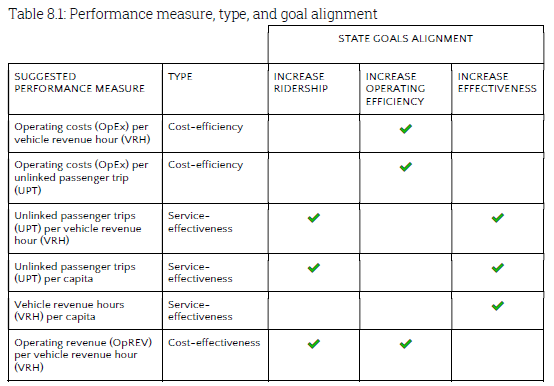

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# read in data
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

# aggregate by categories
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode", "service"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

# set up dict for new columns loop
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

# loop to calculate performance metric and establih column name using dict
for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

In [3]:
# calculated metrics resulted NaN and inf files!
df_agg.describe()

,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,4.120000e+02,4.120000e+02,4.120000e+02,4.120000e+02,408.0000,408.000,401.000000,401.000000,408.0000
mean,1.350351e+07,5.895806e+05,8.905891e+06,1.128427e+08,inf,inf,9.795536,0.785162,inf
std,7.473039e+07,2.170119e+06,3.204041e+07,4.762770e+08,NaN,NaN,13.854108,1.527742,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,21.9300,0.520,0.620000,0.050000,1.8600
25%,8.945825e+04,2.438250e+04,2.847868e+05,2.550923e+06,83.9625,6.015,2.610000,0.180000,10.4400
50%,3.397565e+05,7.177300e+04,1.094216e+06,7.698016e+06,117.0100,8.680,5.380000,0.370000,20.7200
75%,2.503036e+06,3.082510e+05,4.838555e+06,3.968497e+07,154.2250,12.320,11.210000,0.780000,46.0475
max,1.249836e+09,3.490394e+07,4.351329e+08,6.949403e+09,inf,inf,122.010000,18.510000,inf


## Dealing with `NaN` and `inf` values
Some of the metric calculation results in either `inf` or `NaN` values due to divide-by-zero scenarios. These values break the standard devatition calculation and visuals

Comparing removing rows with zero values vs. removing rows with inf/NaN values resulted in equivilent dataframes. 



In [4]:
# 1. remove rows with zero values for each metric
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

# 3. What are the rows with zero values?
zero_rows = df_agg[
    (df_agg["upt"] == 0)
    | (df_agg["vrh"] == 0)
    | (df_agg["vrm"] == 0)
    | (df_agg["opexp_total"] == 0)
]


## Comparing initial aggregated dataframe to datafrom without zero values

In [5]:
display(
    f"How many rows were removed from the initial dataframe? {len(df_agg)-len(no_zero_rows)}",
    "Which agencies/rows were removed?",
    zero_rows.sort_values(by="agency_name")
)

'How many rows were removed from the initial dataframe? 11'

'Which agencies/rows were removed?'

,ntd_id,city,agency_name,mode,service,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
274,90227,Moorpark,City of Moorpark (MCT) - Public Works,Demand Response,Purchased Transportation,0,0,0,0,NaN,NaN,NaN,NaN,NaN
411,99438,Redding,County of Shasta Department of Public Works,Bus,Purchased Transportation,0,0,0,524107,inf,inf,NaN,NaN,inf
381,90298,Ventura,County of Ventura (PWATD) - Public Works,Demand Response,Purchased Transportation,0,0,0,0,NaN,NaN,NaN,NaN,NaN
106,90036,Orange,Orange County Transportation Authority (OCTA),Streetcar,Purchased Transportation,0,0,0,0,NaN,NaN,NaN,NaN,NaN
61,90019,Sacramento,Sacramento Regional Transit District,Demand Response,Purchased Transportation,0,0,0,1342362,inf,inf,NaN,NaN,inf
62,90019,Sacramento,Sacramento Regional Transit District,Demand Response,Purchased Transportation - Taxi,0,0,0,65616,inf,inf,NaN,NaN,inf
64,90019,Sacramento,Sacramento Regional Transit District,Demand Response Taxi,Purchased Transportation,0,0,0,121701,inf,inf,NaN,NaN,inf
0,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Bus,Purchased Transportation,0,0,0,19580,inf,inf,NaN,NaN,inf
1,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Demand Response,Purchased Transportation,0,0,0,2396004,inf,inf,NaN,NaN,inf
39,90013,San Jose,Santa Clara Valley Transportation Authority (VTA),Heavy Rail,Directly Operated,0,0,0,0,NaN,NaN,NaN,NaN,NaN


### Conclusion
11 rows with either zero,inf,NaN values were identified. Both methods (filtering out zero-values and filtering out inf/NaN values) resulted in equivilent results.

Moving forward with `no_zero_rows` for the remainder of the analysis.

## Overall Summary Statistics

In [6]:
all_metrics = [
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list= [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

In [7]:
no_zero_rows[all_metrics].describe()

,upt_per_vrh,upt_per_vrm,opex_per_vrh,opex_per_vrm,opex_per_upt
count,401.000000,401.000000,401.000000,401.000000,401.000000
mean,9.795536,0.785162,152.473890,11.755387,29.377781
std,13.854108,1.527742,205.996039,20.775520,24.157545
min,0.620000,0.050000,21.930000,0.520000,1.860000
25%,2.610000,0.180000,83.280000,5.960000,10.290000
50%,5.380000,0.370000,116.130000,8.580000,20.540000
75%,11.210000,0.780000,150.660000,12.000000,44.770000
max,122.010000,18.510000,2740.980000,327.640000,119.070000


In [8]:
# melting dataframe for visuals
no_zero_rows_melt = pd.melt(
    no_zero_rows,
    id_vars=["ntd_id", "city", "agency_name", "mode", "service"],
    value_vars=[
        "opex_per_vrh",
        "opex_per_vrm",
        "upt_per_vrh",
        "upt_per_vrm",
        "opex_per_upt",
    ],
    var_name="performance_metrics",
    value_name="metric_units",
)


In [9]:
def metrics_charts(metrics_list: list, df: pd.DataFrame):
    """Function produces 3 charts: Box plot, bar chart, histogram.
    Takes in a dataframe and loops through a list of performance metrics.
    """
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    for i in metrics_list:
        # box plot
        box_plot = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_boxplot(extent="min-max")
            .encode(y="mode:N", x="metric_units:Q")
            .properties(
                title=f"Box Plot for {i}",
                width="container",
                height=300,
            )
        ).interactive()

        # bar chart
        bar_chart = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                x=alt.X("agency_name:N", sort="-y"),
                y=alt.Y("metric_units:Q", title=i),
                color="service:N",
                tooltip=[
                    "agency_name:N", 
                    "mode:N", 
                    "service:N", 
                    "metric_units:Q",
                ],
                opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2)),
            )
            .properties(
                width=400,
                height=200,
            )
            .facet("mode:N", columns=3, title=f"Barchart For All {i}")
            .resolve_scale(x="independent", y="independent")
            .add_params(
                selection
            )
        )
        
        # distribution plot
        histogram = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                alt.X("metric_units:Q",
                      bin=alt.Bin(step=5),
                      # bin=True),
                     ).bin(maxbins=100),
                y="count()",
                tooltip=[
                    "count()",
                    alt.Tooltip('metric_units:Q', bin=alt.Bin(step=5), title=f'bin range for {i}')
                ],
            )
            .properties(
                title=f"{i} Distribution",
                width=500,  # smaller width per facet
                height=200,
            )
            .facet("mode:N", columns=3)
            .resolve_scale(x="independent", y="independent")
        ).interactive()


        display(
            f"Box plot for {i}",
            box_plot,
            f"Statewide Bar Chart for {i}",
            bar_chart,
            f"Histogram Chart for {i}",
            histogram,
        )
        print("")

## Statewide Service-Effectiveness Metrics

### Unlinked Passenger Trips per Vehicle Revenue Hours
upt_per_vrh

In [10]:
metrics_charts(metrics_list=["upt_per_vrh"], df=no_zero_rows_melt)

'Box plot for upt_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrh'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrh'

alt.FacetChart(...)

### Unlinked Passenger Trips by Vehicle Revenue Miles
upt_per_vrm

In [11]:
metrics_charts(metrics_list=["upt_per_vrm"], df=no_zero_rows_melt)

'Box plot for upt_per_vrm'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrm'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrm'

alt.FacetChart(...)

## Statewide Cost-Effecticeness Metrics

### Operating Expense per Vehicle Revenue Hours
opex_per_vrh

In [12]:
metrics_charts(["opex_per_vrh"], df=no_zero_rows_melt)

'Box plot for opex_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for opex_per_vrh'

alt.FacetChart(...)

'Histogram Chart for opex_per_vrh'

alt.FacetChart(...)

### Operating Expense per Vehicle Revenue Miles
opex_per_vrm

In [13]:
metrics_charts(["opex_per_vrm"], df=no_zero_rows_melt)

'Box plot for opex_per_vrm'

alt.Chart(...)

'Statewide Bar Chart for opex_per_vrm'

alt.FacetChart(...)

'Histogram Chart for opex_per_vrm'

alt.FacetChart(...)

### Operating Expense per Unlinked Passenger Trips
opex_per_upt

In [14]:
metrics_charts(["opex_per_upt"], df=no_zero_rows_melt)

'Box plot for opex_per_upt'

alt.Chart(...)

'Statewide Bar Chart for opex_per_upt'

alt.FacetChart(...)

'Histogram Chart for opex_per_upt'

alt.FacetChart(...)

## Bottom 5% of Performance Metrics


### Bottom 5% Service-Effectiveness Metrics

In [15]:
## SPLIT other chart test
# Who are the bottom 5% of each performance metrics

for metric_name in service_metrics_list:
    service_cutoff = no_zero_rows[metric_name].quantile(0.05)
    service_bottom = no_zero_rows[no_zero_rows[metric_name] <= service_cutoff][
        ["agency_name", "mode", "service", metric_name]
    ]
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    display(
        print(f"""Service-effectivness: Bottom 5% of {metric_name}
        """),
        
        alt.Chart(service_bottom).mark_bar().encode(
            x=alt.X("agency_name:N", sort="y"),
            xOffset="mode:N",
            color="service:N",
            y=alt.Y(metric_name, stack=None),
            tooltip=["agency_name", "mode", metric_name],
            opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2))
        ).properties(title=f"Bottom 5% {metric_name}", width="container").add_params(selection),
        service_bottom.sort_values(by=metric_name, ascending=True),
                )

Service-effectivness: Bottom 5% of upt_per_vrh
        


None

alt.Chart(...)

,agency_name,mode,service,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Demand Response,Purchased Transportation,0.62
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,1.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,1.11
170,Livermore / Amador Valley Transit Authority (L...,Demand Response,Purchased Transportation,1.32
309,City of Carson - Transportation Services Division,Bus,Directly Operated,1.32
202,City of Union City (UCT) - Public Works,Demand Response,Purchased Transportation,1.33
374,City of West Hollywood (WEHO) - Business Devel...,Demand Response,Purchased Transportation,1.36
365,City of Rosemead - Public Works,Demand Response,Purchased Transportation,1.37
297,City of Bell - Community Services Department,Demand Response,Purchased Transportation,1.37
267,"Paratransit, Inc.",Demand Response,Purchased Transportation,1.37


Service-effectivness: Bottom 5% of upt_per_vrm
        


None

alt.Chart(...)

,agency_name,mode,service,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,0.05
400,City of Escalon - Transit Services,Bus,Purchased Transportation,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,Purchased Transportation,0.07
96,Riverside Transit Agency (RTA),Demand Response Taxi,Purchased Transportation,0.07
272,Imperial County Transportation Commission (ICTC),Demand Response,Purchased Transportation,0.08
151,City of Visalia (VT) - Transportation,Commuter Bus,Purchased Transportation,0.08
95,Riverside Transit Agency (RTA),Demand Response,Purchased Transportation - Taxi,0.08
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,0.08
139,SunLine Transit Agency,Vanpool,Purchased Transportation,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,0.09


### Bottom 5% Cost-Effectiveness Metrics

In [16]:
for metric_name in cost_metrics_list:
    cost_cutoff = no_zero_rows[metric_name].quantile(0.95)
    cost_bottom = no_zero_rows[no_zero_rows[metric_name] >= cost_cutoff][
        ["agency_name", "mode", "service", metric_name]
    ]
    
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    display(
        print(f"""Cost-effectivness:Bottom 5% of {metric_name}
        """),
        alt.Chart(cost_bottom).mark_bar().encode(
            x=alt.X("agency_name:N", sort="-y"),
            xOffset= alt.XOffset("mode:N", sort="-y"),
            color="service:N",
            y=alt.Y(metric_name, 
                    # stack=None
                    ),
            tooltip=["agency_name", "mode", metric_name],
            opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2))
        ).properties(title=f"Bottom 5% {metric_name}", width="container").add_params(selection),
        
        cost_bottom.sort_values(by=metric_name, ascending=False)
    )

Cost-effectivness:Bottom 5% of opex_per_vrh
        


None

alt.Chart(...)

,agency_name,mode,service,opex_per_vrh
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,2740.98
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,2145.69
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,1048.84
225,Altamont Corridor Express (ACE),Commuter Rail,Purchased Transportation,1015.05
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,924.74
184,Southern California Regional Rail Authority (S...,Commuter Rail,Purchased Transportation,739.19
85,North County Transit District (NCTD),Commuter Rail,Directly Operated,703.64
89,North County Transit District (NCTD),Hybrid Rail,Purchased Transportation,701.78
167,Peninsula Corridor Joint Powers Board (PCJPB),Commuter Rail,Purchased Transportation,689.42
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,676.42


Cost-effectivness:Bottom 5% of opex_per_vrm
        


None

alt.Chart(...)

,agency_name,mode,service,opex_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,327.64
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,206.07
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,105.29
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,91.20
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,47.66
50,City and County of San Francisco (SFMTA) - Tra...,Light Rail,Directly Operated,46.57
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,42.20
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,40.12
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,35.76
89,North County Transit District (NCTD),Hybrid Rail,Purchased Transportation,31.98


Cost-effectivness:Bottom 5% of opex_per_upt
        


None

alt.Chart(...)

,agency_name,mode,service,opex_per_upt
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,119.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,111.53
30,San Joaquin Regional Transit District (RTD),Demand Response,Directly Operated,106.91
118,City of Commerce (CCT) - Transportation,Demand Response,Directly Operated,99.16
352,City of Malibu - Community Services Department,Demand Response,Purchased Transportation,96.60
363,City of Pico Rivera - Transit Division/Parks a...,Demand Response,Purchased Transportation,96.55
309,City of Carson - Transportation Services Division,Bus,Directly Operated,95.41
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,94.66
247,City of Elk Grove(etran),Demand Response,Purchased Transportation,91.47
249,San Luis Obispo Regional Transit Authority (SL...,Demand Response,Directly Operated,88.72


---